# Kickstarter: Classification
Tests Include:
-KNN
-Logistic Regression
-Decision Trees
-Random Forest
-SVM
-Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, RandomTreesEmbedding
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

import datetime
import warnings
import os

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
df = pd.read_pickle('data/kickstarter_data_ds2.pkl')
df['idx'] = df['id']
df = df.set_index('idx')
# df['state'] = df['state'].replace({'failed': 0, 'successful': 1})
# df = pd.read_sql_query('''SELECT * FROM kickstarter_data_ds2''',engine)
print(df.shape)
# pd.read_sql_query('''SELECT state, main_category, main_category, currency, currency, deadline, launched, usd_goal_real, usd_pledged_real FROM kickstarter_data_ds2 LIMIT 5''',engine)
print(df.columns)
df.head()

(163425, 19)
Index(['id', 'name', 'state', 'category_main', 'category_name',
       'backers_count', 'pct_goal_achieved', 'usd_pledged', 'usd_goal',
       'country', 'currency', 'campaign_length', 'deadline', 'launched',
       'created', 'staff_pick', 'spotlight', 'creator_name', 'blurb_length'],
      dtype='object')


,id,name,state,category_main,category_name,backers_count,pct_goal_achieved,usd_pledged,usd_goal,country,currency,campaign_length,deadline,launched,created,staff_pick,spotlight,creator_name,blurb_length
idx,,,,,,,,,,,,,,,,,,,
1396766240,1396766240,Ripple Playing Cards - Printed by USPCC,failed,games,Playing Cards,131,0.3,3387.000000,9999.000000,US,USD,38,2018-01-12,2017-12-05,2017-10-08,0,False,B.Y. Eidelman,16
2065169465,2065169465,Cotton-Top Pastries,successful,food,Small Batch,99,1.3,9858.000000,7500.000000,US,USD,30,2018-01-12,2017-12-13,2017-12-12,1,True,Holly Weist,5
1647325451,1647325451,Code Switch,successful,film_and_video,Horror,34,1.5,4611.000000,3000.000000,US,USD,32,2018-01-12,2017-12-11,2017-11-10,0,True,Alba Roland,23
727157486,727157486,Rain Dog Farm,failed,food,Farms,49,0.3,4741.000000,18000.000000,US,USD,38,2018-01-12,2017-12-05,2017-11-28,1,False,Charlie Wainger,9
1756145145,1756145145,WANGTA: a novel,successful,publishing,Fiction,13,1.0,427.185132,427.185132,CA,CAD,21,2018-01-12,2017-12-22,2017-12-18,0,True,D. H. de Bruin,22


In [6]:
start_date = datetime.datetime.strptime('2016-01-01', "%Y-%m-%d").date()

df = df[df['launched'] >= start_date] # filter from start date to current
df = df[['state','category_main','category_name','backers_count','usd_goal','country','currency','campaign_length',
        'staff_pick','blurb_length']]
df = df.dropna()

df.shape

(38401, 10)

In [7]:
df.columns

Index(['state', 'category_main', 'category_name', 'backers_count', 'usd_goal',
       'country', 'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object')

In [8]:
df_dummies = pd.get_dummies(df[['state','category_main','category_name', 'country','currency']],drop_first=True)
df = df_dummies.merge(df,how='inner',left_index=True, right_index=True)
print(df.shape)
print(df.columns)
df.info()

(38401, 198)
Index(['state_successful', 'category_main_comics', 'category_main_crafts',
       'category_main_dance', 'category_main_design', 'category_main_fashion',
       'category_main_film_and_video', 'category_main_food',
       'category_main_games', 'category_main_journalism',
       ...
       'state', 'category_main', 'category_name', 'backers_count', 'usd_goal',
       'country', 'currency', 'campaign_length', 'staff_pick', 'blurb_length'],
      dtype='object', length=198)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38401 entries, 1396766240 to 1094069811
Columns: 198 entries, state_successful to blurb_length
dtypes: float64(1), int64(4), object(5), uint8(188)
memory usage: 11.4+ MB


In [9]:
# removing all variables that cannot be known before a campaign is launched, such as # backers and $ pledged
df = df.dropna()
df = df.drop(['state','category_main','category_name', 'backers_count', 'country', 'currency'], 1)
# df.to_csv('data/kickstarter_data_ds2_app.csv')
X = df.drop(['state_successful'], 1)
y = df['state_successful']

print(X.shape)
print(X.columns)
# X.head()
X.shape

(38401, 191)
Index(['category_main_comics', 'category_main_crafts', 'category_main_dance',
       'category_main_design', 'category_main_fashion',
       'category_main_film_and_video', 'category_main_food',
       'category_main_games', 'category_main_journalism',
       'category_main_music',
       ...
       'currency_MXN', 'currency_NOK', 'currency_NZD', 'currency_SEK',
       'currency_SGD', 'currency_USD', 'usd_goal', 'campaign_length',
       'staff_pick', 'blurb_length'],
      dtype='object', length=191)


(38401, 191)

## Assumptions

In [10]:
results_dict = {}

def plot_results(classifier,X,y, test_size=0.3, standardize='y'): # add standardize as input
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=42)
    if standardize == 'y':
        scaler = StandardScaler().fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)
    model = classifier.fit(X_train, y_train)
        
    # calculate and print accuracy score
    train_acc=model.score(X_train, y_train)
    test_acc=model.score(X_test,y_test)
    
    # calculate ROC
    y_score=model.predict_proba(X_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # calculate confusion matrix
    y_true = y_test
    y_pred = model.predict(X_test)
    conf = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(conf)

    # Plots
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    # Confusion Matrix
    ax = plt.subplot(121)

    plt.imshow(conf, interpolation='nearest',cmap=cm.YlGn)

    plt.title("Confusion Matrix",fontweight='bold',fontsize=15)
    plt.text(0,0,conf[0][0],fontsize=18,fontweight='bold',color='orange',ha='center')
    plt.text(1,0,conf[0][1],fontsize=18,fontweight='bold',color='orange',ha='center')
    plt.text(0,1,conf[1][0],fontsize=18,fontweight='bold',color='orange',ha='center')
    plt.text(1,1,conf[1][1],fontsize=18,fontweight='bold',color='orange',ha='center')
    ax.set_xlabel("Predicted", fontweight='bold',color='k',fontsize=12)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Success','Fail'],fontsize=12)
    ax.set_ylabel("Actual",fontweight='bold',color='k',fontsize=12)
    ax.set_yticks([0,1])
    ax.set_yticklabels(['Success','Fail'],rotation=90, fontsize=12)
    plt.tight_layout()

    # ROC Curve
    ax = plt.subplot(122)
    plt.title("ROC Curve",fontweight='bold',fontsize=15)
    plt.plot([0,1],[0,1],'k:')
    plt.plot(fpr,tpr,color='g',label='AUC: {}%'.format(round(100*roc_auc_score(y_test,y_pred),2)))
    plt.xlabel('FPR',fontweight='bold',fontsize=12)
    plt.ylabel('TPR',fontweight='bold',fontsize=12)
    plt.axis('scaled')
    plt.tight_layout()
    plt.legend(loc='lower right')
#     results_dict[classifier] = [train_acc,test_acc, roc_auc, classification_report(y_test, model.predict(X_test))]
    
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
#     print("AUC:     %0.2f" %(roc_auc_score(y_test,y_pred)))
    print(classification_report(y_test, model.predict(X_test)))

[[4734 1586]
 [1245 3956]]
Training Data Accuracy: 0.76
Test Data Accuracy:     0.75
             precision    recall  f1-score   support

          0       0.71      0.76      0.74      5201
          1       0.79      0.75      0.77      6320

avg / total       0.76      0.75      0.75     11521



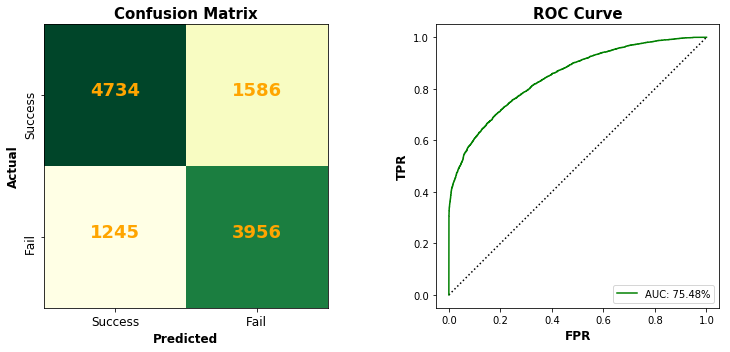

In [11]:
model = LogisticRegression(C=1000, penalty='l1')
plot_results(model,X,y,test_size=0.3)

In [12]:
# df = pd.DataFrame(results_dict)
# df

[[4888 1432]
 [1139 4062]]
Training Data Accuracy: 0.79
Test Data Accuracy:     0.78
             precision    recall  f1-score   support

          0       0.74      0.78      0.76      5201
          1       0.81      0.77      0.79      6320

avg / total       0.78      0.78      0.78     11521



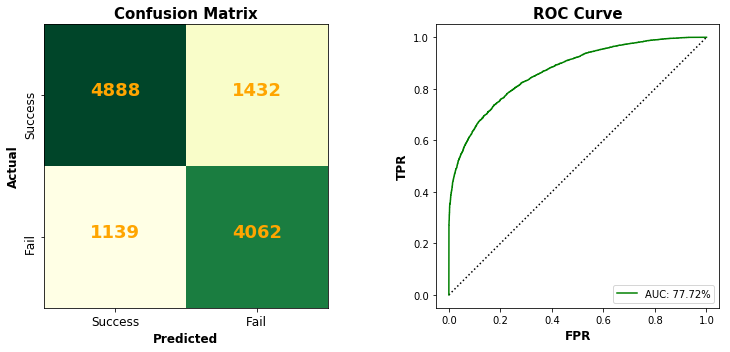

In [13]:
model = GradientBoostingClassifier(n_estimators=500)
plot_results(model,X,y,test_size=0.3)

[[4909 1411]
 [1139 4062]]
Training Data Accuracy: 0.80
Test Data Accuracy:     0.78
             precision    recall  f1-score   support

          0       0.74      0.78      0.76      5201
          1       0.81      0.78      0.79      6320

avg / total       0.78      0.78      0.78     11521



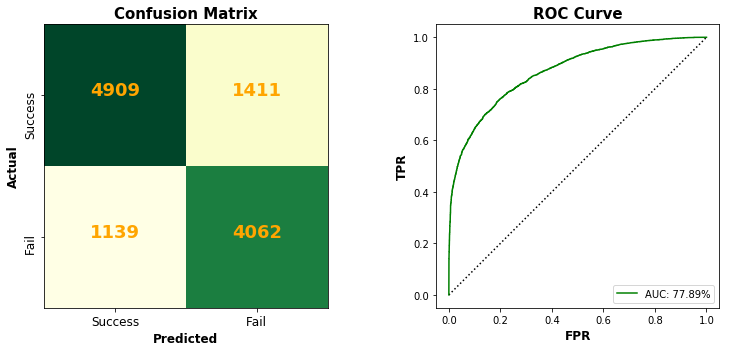

In [14]:
model = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
                       min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
                       objective='reg:linear', reg_alpha=0, reg_lambda=1,
                       scale_pos_weight=1, seed=0, silent=1, subsample=0.8)
plot_results(model,X,y,test_size=0.3)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

k_range = list(range(1, 101))
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(26880, 191) (26880,)
(11521, 191) (11521,)


In [16]:
# https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
# scaler = StandardScaler().fit(X_train)
# X_train_s = scaler.transform(X_train)
# X_test_s = scaler.transform(X_test)
# print(X_train_s.mean(axis=0))
# print(X_train_s.std(axis=0))

# X_combined_s = np.vstack((X_train_s, X_test_s))
# y_combined = np.hstack((y_train, y_test))

## Phase 2: Deeper Dive: Logistic Regression, Naive Bayes, Random Forests?

In [17]:
# Define models to test
model_list = [ # ['BernoulliNB', BernoulliNB(alpha=2.0)], # F1 0.60
#                 ['MultinomialNB', MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)], 
#                 ['DecisionTree', DecisionTreeClassifier()], 
#                 ['RandomForest', RandomForestClassifier(max_features='sqrt',n_estimators=1000)], # F1 0.61
                ['GradientBoost', GradientBoostingClassifier(n_estimators=500)],
                ['XGBoost', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
                       min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
                       objective='reg:linear', reg_alpha=0, reg_lambda=1,
                       scale_pos_weight=1, seed=0, silent=1, subsample=0.8)],
#                 ['AdaBoost', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())],
#                 ['KNN', KNeighborsClassifier(38)], # best k from KNN model below; scale data
                ['LogisticRegression', LogisticRegression(C=1000, penalty='l1')]]
#                 ['LogisticRegressionCV', LogisticRegressionCV()]] # scale data; F1 0.62
#                 ['SVM', SVC(probability=True)]] # scale data; F1 0.57

# model_list_s = [['LogisticRegression', LogisticRegression()]] # scale data
#                 ['LogisticRegressionCV', LogisticRegressionCV()]] # scale data
#                 ['SVM', SVC(probability=True)]] # scale data

# Calculate metrics for each model
roc = {}
for model in model_list:
#     if model in model_list_s:
#         X_train = X_train_s
#         X_test = X_test_s
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision_1 = []
    precision_0 = []
    recall_1 = []
    recall_0 = []
    f1_1 = []
    f1_0 = []
    auc = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=42, shuffle=True) 
    for train_idx, test_idx in kf.split(X, y=y):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision_1.append(precision_score(y_test, y_pred ,pos_label=1))
        precision_0.append(precision_score(y_test, y_pred ,pos_label=0))
        recall_1.append(recall_score(y_test, y_pred, pos_label=1))
        recall_0.append(recall_score(y_test, y_pred, pos_label=0))
        f1_1.append(f1_score(y_test, y_pred, pos_label=1))
        f1_0.append(f1_score(y_test, y_pred, pos_label=0))
        auc.append(roc_auc_score(y_test, y_pred))
        
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision_1 = np.mean(precision_1)
    mean_precision_0 = np.mean(precision_0)
    mean_recall_1 = np.mean(recall_1)
    mean_recall_0 = np.mean(recall_0)
    mean_f1_1 = np.mean(f1_1)
    mean_f1_0 = np.mean(f1_0)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test)[:,1]
    roc[model_name] = roc_curve(y_test, y_score), mean_auc
    results_dict[model_name] = {"accuracy": mean_accuracy, "precision_s": mean_precision_1, "precision_f": mean_precision_0, "recall_s": mean_recall_1, "recall_f": mean_recall_0, "f1_s": mean_f1_1, "f1_f": mean_f1_0, "auc": mean_auc}

    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tAUC:', mean_auc)
    print('\n')
    print(classification_report(y_test,y_pred)) 
    print(confusion_matrix(y_test,y_pred))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
	Accuracy: 0.776790209183
	AUC: 0.777153006116


             precision    recall  f1-score   support

          0       0.74      0.78      0.76      5201
          1       0.81      0.77      0.79      6320

avg / total       0.78      0.78      0.78     11521

[[4060 1141]
 [1432 4888]]
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
       objective='reg:linea

In [18]:
# # Plot the ROC curve from the last K-Fold split
# fig, ax = plt.subplots(figsize=(10, 10))
# colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange','darkorchid','bisque']

# # Plot 50-50 Line
# ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# # Plot Classifier ROC Curves
# for key, c in zip(roc.keys(), colors):
#     ax.plot(roc[key][0], roc[key][1], color=c, label=key)
    
# ax.set_xlabel('FPR')
# ax.set_ylabel('TPR')
# ax.set_title('ROC Curve - Select Models')
# ax.legend(loc='best')
# plt.savefig('charts/roc_ds2_p2.png')

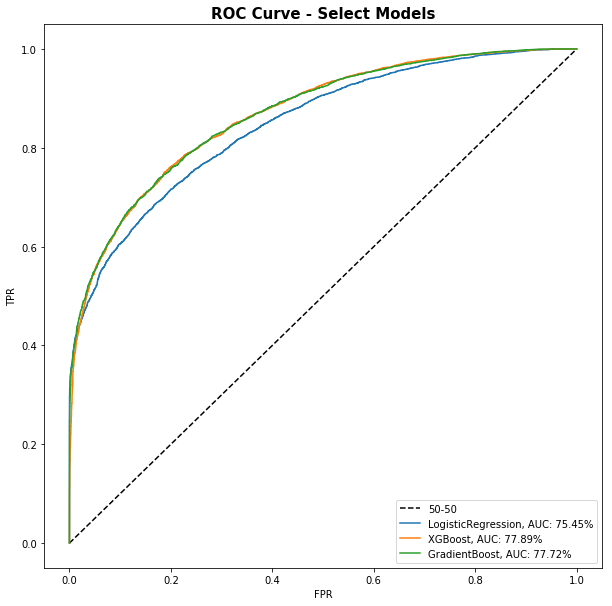

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
# colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange','darkorchid','bisque']

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Classifier ROC Curves
for key, value in roc.items():
#     print(value[1])
    label = '{}, AUC: {}%'.format(key, round(100*value[1],2))
    ax.plot(roc[key][0][0], roc[key][0][1], label=label)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve - Select Models',fontweight='bold',fontsize=15)
ax.legend(loc='lower right')
plt.savefig('charts/roc_ds2_p2.png')

In [20]:
rd = pd.DataFrame(results_dict).T
rd = rd.apply(lambda x: round(100*x,2).astype(str) + "%")
# rd['f1_success'] = rd['f1']
rd = rd.sort_values(['auc'],ascending=[False])
rd

,accuracy,auc,f1_f,f1_s,precision_f,precision_s,recall_f,recall_s
XGBoost,77.87%,77.89%,76.11%,79.38%,74.22%,81.17%,78.1%,77.67%
GradientBoost,77.68%,77.72%,75.95%,79.17%,73.93%,81.09%,78.09%,77.34%
LogisticRegression,75.4%,75.45%,73.61%,76.96%,71.36%,79.14%,76.02%,74.89%


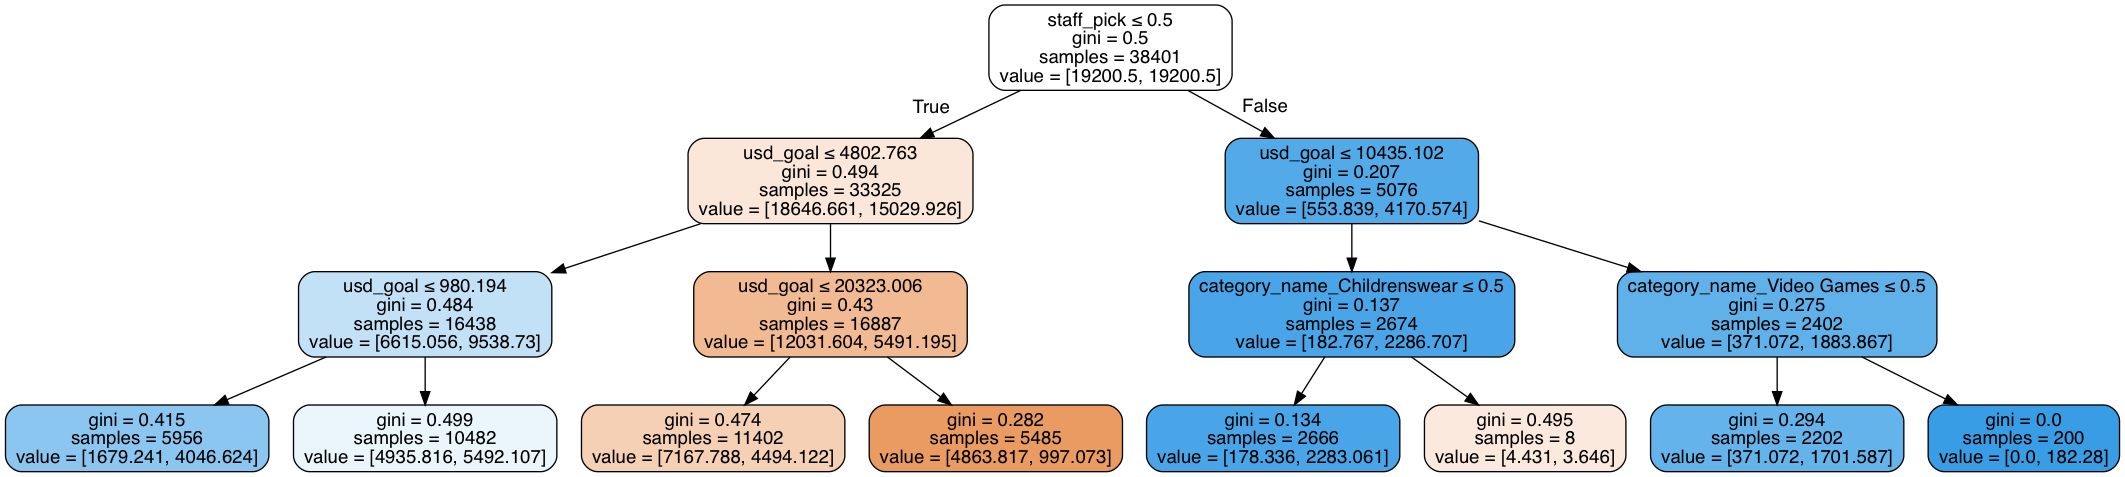

In [21]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dt = DecisionTreeClassifier(max_depth=3,class_weight='balanced')
dot_data = StringIO()
dt.fit(X,y)
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [22]:
rf = RandomForestClassifier(max_features='sqrt',n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_score = rf.predict_proba(X_test)[:,1]
fpr, tpr,_ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(y_test, rf.predict(X_test)))
print(metrics.classification_report(y_test, rf.predict(X_test)))
print(metrics.confusion_matrix(y_test,rf.predict(X_test)))
print('ROC AUC:', roc_auc)

TypeError: 'list' object is not callable

In [ ]:
features = pd.DataFrame()
features['importances'] = rf.feature_importances_
features['features'] = X_train.columns
features.sort_values('importances',ascending = False)